In [64]:
# Import packages and set seed for reproducibility
import sys
import torch
import os
import json
import time
import random
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.patheffects as pe
from tqdm import tqdm
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as album
import torchvision
import gc
gc.collect()
torch.cuda.empty_cache()

In [65]:
def set_seed(seed, use_gpu=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        print("CUDA is available")
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 12345
USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())


CUDA is available


In [66]:
DATA_PATH = "./data"
train_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "train_metadata_patches.csv"))
valid_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "valid_metadata_patches.csv"))
test_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "test_metadata_patches.csv"))

train_metadata_df["sat_image_path"] = train_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
train_metadata_df["mask_path"] = train_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))
valid_metadata_df["sat_image_path"] = valid_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
valid_metadata_df["mask_path"] = valid_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))
test_metadata_df["sat_image_path"] = test_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
test_metadata_df["mask_path"] = test_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))


In [67]:
# Load class dictionary
class_dict = pd.read_csv(os.path.join(DATA_PATH, "class_dict.csv"))
class_names = class_dict["name"].tolist()
class_rgb_values = class_dict[["r", "g", "b"]].values.tolist()

In [68]:
# Shuffle and split datasets
train_metadata_df_shuffled = train_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
train_df = train_metadata_df_shuffled.iloc[:60000]
valid_metadata_df_shuffled = valid_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
valid_df = valid_metadata_df_shuffled.iloc[:8000]
test_metadata_df_shuffled = test_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
test_df = test_metadata_df_shuffled.iloc[:8000]


In [69]:
# get image and mask paths of an image
idx = 1
image_path = train_df["sat_image_path"][idx]
mask_path = train_df["mask_path"][idx]

# read image and mask into a numpy array and convert from BGR ot RGB
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)


def get_size(image, mask):

    format_spec = "{:<10} {:<26} {:<18} {:<16} {:<14}"

    image_size = sys.getsizeof(image)/10**6
    mask_size = sys.getsizeof(mask)/10**6

    if torch.is_tensor(image) and torch.is_tensor(mask):
        image_size = sys.getsizeof(image.storage())/10**6
        mask_size = sys.getsizeof(mask.storage())/10**6

    print(format_spec.format("name:", "object type:", "shape:", "data type:", "size [Mb]:"), "\n")
    print(format_spec.format("image", str(type(image)), str(list(image.shape)), str(image.dtype), str(round(image_size, 2))))
    print(format_spec.format("mask", str(type(mask)), str(list(mask.shape)), str(mask.dtype), str(round(mask_size, 2))))

get_size(image, mask)

name:      object type:               shape:             data type:       size [Mb]:     

image      <class 'numpy.ndarray'>    [128, 128, 3]      uint8            0.05          
mask       <class 'numpy.ndarray'>    [128, 128, 3]      uint8            0.05          


In [70]:
def rgb_to_one_hot_econding(mask_rgb, class_rgb_values):

    if mask_rgb.shape[2] != 3:
        raise ValueError("The number of channels must be 3")

    mask_one_hot = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1], len(class_rgb_values)), dtype = "uint8")
    for i, rgb in enumerate(class_rgb_values):
        # np.equal(x, y): return (x == y) element-wise (the smaller array is broadcast to the larger one)
        # np.all(z): test whether all array elements along a given axis evaluate to True
        # numpy automatically converts bool to uint8
        mask_one_hot[:,:,i] = np.all(np.equal(mask_rgb, rgb), axis = -1)

    return mask_one_hot

In [71]:
def rgb_to_dense_encoding(mask_rgb, class_rgb_values):

    if mask_rgb.shape[2] != 3:
        raise ValueError("The number of channels must be 3")

    mask_dense = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype = "uint8")
    for i, rgb in enumerate(class_rgb_values):
        # np.equal(x, y): return (x == y) element-wise (the smaller array is broadcast to the larger one)
        # np.all(z): test whether all array elements along a given axis evaluate to True
        mask_dense[np.all(np.equal(mask_rgb, rgb), axis = -1)] = i

    return mask_dense

In [72]:
def dense_to_rgb_encoding(mask_dense, class_rgb_values):

    if len(mask_dense.shape) != 2:
        raise ValueError("The number of channels must be 1")

    mask_rgb = np.zeros((mask_dense.shape[0], mask_dense.shape[1], 3), dtype = "uint8")
    for i, rgb in enumerate(class_rgb_values):
        mask_rgb[mask_dense == i,:] = rgb

    return mask_rgb

In [73]:
def one_hot_to_rgb_encoding(mask_one_hot, class_rgb_values):

    if mask_one_hot.shape[2] != len(class_rgb_values):
        raise ValueError("The number of channels must be " + str(len(class_rgb_values)))

    mask_dense = np.argmax(mask_one_hot, axis = -1)
    mask_rgb = dense_to_rgb_encoding(mask_dense, class_rgb_values)

    return mask_rgb

In [74]:
freq = np.array([0.2749499,  0.63343763, 0.32669834, 0.28772112, 0.2346999,  0.46751881])
# median frequency balancing
class_weight = np.median(freq)/freq

In [75]:
# Define transformations
train_mean = [79.7510382, 112.14159978, 110.33270898]
train_std = [79.7510382, 112.14159978, 110.33270898]

train_transform = album.Compose([
    album.RandomRotate90(p=1),
    album.HorizontalFlip(p=0.5),
    album.VerticalFlip(p=0.5),
    album.Transpose(p=0.5),
    album.ColorJitter(p=0.5),
    album.Normalize(mean=[m/255 for m in train_mean], std=[s/255 for s in train_std])
])

valid_transform = album.Compose([
    album.Normalize(mean=[m/255 for m in train_mean], std=[s/255 for s in train_std])
])

test_transform = album.Compose([
    album.Normalize(mean=[m/255 for m in train_mean], std=[s/255 for s in train_std])
])


In [76]:
class DeepGlobeLandCover(Dataset):
    def __init__(self, df, class_rgb_values=None, transform=None):
        self.image_paths = df["sat_image_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        self.class_rgb_values = class_rgb_values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])
        mask = cv2.imread(self.mask_paths[i])

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        mask = rgb_to_dense_encoding(mask, self.class_rgb_values)

        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).long().view(-1)

        return image, mask


In [77]:
# Helper functions for encoding
def rgb_to_dense_encoding(mask_rgb, class_rgb_values):
    if mask_rgb.shape[2] != 3:
        raise ValueError("The number of channels must be 3")

    mask_dense = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype="uint8")
    for i, rgb in enumerate(class_rgb_values):
        mask_dense[np.all(np.equal(mask_rgb, rgb), axis=-1)] = i

    return mask_dense

In [78]:
# Dataset and Dataloader
train_dataset = DeepGlobeLandCover(train_df, class_rgb_values, train_transform)
valid_dataset = DeepGlobeLandCover(valid_df, class_rgb_values, valid_transform)
test_dataset = DeepGlobeLandCover(test_df, class_rgb_values, test_transform)

BATCH_SIZE = 16
train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

# Sample Batch Verification
batch = next(iter(train_iterator))
image_batch, mask_batch = batch
print(f"Image Batch Shape: {image_batch.shape}")
print(f"Mask Batch Shape: {mask_batch.shape}")


Image Batch Shape: torch.Size([16, 3, 128, 128])
Mask Batch Shape: torch.Size([16, 16384])


In [79]:
batch = next(iter(train_iterator))
get_size(*batch)

name:      object type:               shape:             data type:       size [Mb]:     

image      <class 'torch.Tensor'>     [16, 3, 128, 128]  torch.float32    3.15          
mask       <class 'torch.Tensor'>     [16, 16384]        torch.int64      2.1           


In [80]:
def compute_CM_elements(y_pred, y):
    y_pred_onehot = F.one_hot(y_pred, num_classes=6).bool()
    y_onehot = F.one_hot(y, num_classes=6).bool()

    TP = torch.sum(torch.logical_and(y_pred_onehot, y_onehot), dim=0)
    FP = torch.sum(y_pred_onehot, dim=0) - TP
    TN = torch.sum(torch.logical_and(~y_pred_onehot, ~y_onehot), dim=0)
    FN = torch.sum(~y_pred_onehot, dim=0) - TN

    return TP, FP, TN, FN

In [81]:
def compute_metrics(loss, TP, FP, TN, FN):
    
    # loss
    loss = loss
    
    # IoU dan MA_IoU
    IoU = TP / (TP + FP + FN)
    MA_IoU = torch.sum(IoU) / 6
    
    # Akurasi dan MA_Akurasi
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    MA_accuracy = torch.sum(accuracy) / 6
    
    # Presisi dan MA_Presisi
    precision = TP / (TP + FP)
    MA_precision = torch.sum(precision) / 6
    
    # Recall dan MA_Recall
    recall = TP / (TP + FN)
    MA_recall = torch.sum(recall) / 6
    
    # F1_Skor dan MA_F1_Skor
    F1_score = 2 * (precision * recall) / (precision + recall)
    MA_F1_score = 2 * (MA_precision * MA_recall) / (MA_precision + MA_recall)

    metrics = {
        "loss": loss.item(),
        "IoU": IoU.tolist(),
        "MA_IoU": MA_IoU.item(),
        "accuracy": accuracy.tolist(),
        "MA_accuracy": MA_accuracy.item(),
        "precision": precision.tolist(),
        "MA_precision": MA_precision.item(),
        "recall": recall.tolist(),
        "MA_recall": MA_recall.item(),
        "F1_score": F1_score.tolist(),
        "MA_F1_score": MA_F1_score.item()
    }
    
    return metrics


In [82]:
def train(model, iterator, criterion, optimizer, device, desc="Train"):
    epoch_loss = 0
    epoch_TP = torch.zeros(6).to(device)
    epoch_FP = torch.zeros(6).to(device)
    epoch_TN = torch.zeros(6).to(device)
    epoch_FN = torch.zeros(6).to(device)
    model.train()

    for x, y in tqdm(iterator, desc=desc):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        # Flatten target to `(batch_size * height * width)`
        y = y.view(-1)

        # Model output: `(batch_size, n_classes, height, width)`
        y_logits = model(x)

        # Reshape output to `(batch_size * height * width, n_classes)`
        y_logits = y_logits.view(-1, 6)

        loss = criterion(y_logits, y)

        TP, FP, TN, FN = compute_CM_elements(y_logits.argmax(dim=1), y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss / len(iterator)
        epoch_TP += TP
        epoch_FP += FP
        epoch_TN += TN
        epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics


In [83]:
def evaluate(model, iterator, criterion, device, desc="Valid"):
    epoch_loss = 0
    epoch_TP = torch.zeros(6).to(device)
    epoch_FP = torch.zeros(6).to(device)
    epoch_TN = torch.zeros(6).to(device)
    epoch_FN = torch.zeros(6).to(device)
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(iterator, desc=desc):
            x = x.to(device)
            y = y.to(device)

            # Flatten target to `(batch_size * height * width)`
            y = y.view(-1)

            # Model output: `(batch_size, n_classes, height, width)`
            y_logits = model(x)

            # Reshape output to `(batch_size * height * width, n_classes)`
            y_logits = y_logits.view(-1, 6)

            loss = criterion(y_logits, y)

            TP, FP, TN, FN = compute_CM_elements(y_logits.argmax(dim=1), y)

            epoch_loss += loss / len(iterator)
            epoch_TP += TP
            epoch_FP += FP
            epoch_TN += TN
            epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics


In [84]:
def model_training(n_epochs, model, train_iterator, valid_iterator, criterion, optimizer, scheduler, device,
                   checkpoint_name="checkpoint_vgg.pt", results_name="results_vgg.csv"):
    best_valid_loss = float('inf')
    train_metrics_log = {}
    valid_metrics_log = {}

    print("----------------------------------------------------------")

    for epoch in range(n_epochs):
        print(f"\nEpoch: {epoch + 1}/{n_epochs}\n")
        start_time = time.time()
        train_metrics = train(model, train_iterator, criterion, optimizer, device, desc="Train")
        valid_metrics = evaluate(model, valid_iterator, criterion, device, desc="Valid")

        print(f"\nTrain:",
              f"Loss = {train_metrics['loss']:.4f},",
              f"MA_IoU = {train_metrics['MA_IoU'] * 100:.2f} %,",
              f"MA_acc = {train_metrics['MA_accuracy'] * 100:.2f} %,",
              f"MA_prec = {train_metrics['MA_precision'] * 100:.2f} %,",
              f"MA_rec = {train_metrics['MA_recall'] * 100:.2f} %,",
              f"MA_F1_score = {train_metrics['MA_F1_score'] * 100:.2f} %")
        
        print(f"Valid:",
              f"Loss = {valid_metrics['loss']:.4f},",
              f"MA_IoU = {valid_metrics['MA_IoU'] * 100:.2f} %,",
              f"MA_acc = {valid_metrics['MA_accuracy'] * 100:.2f} %,",
              f"MA_prec = {valid_metrics['MA_precision'] * 100:.2f} %,",
              f"MA_rec = {valid_metrics['MA_recall'] * 100:.2f} %,",
              f"MA_F1_score = {valid_metrics['MA_F1_score'] * 100:.2f} %")

        if scheduler:
            scheduler.step()

        end_time = time.time()
        print(f"\nEpoch Time: {end_time-start_time:.2f} s\n")
        print("----------------------------------------------------------")
        
        if valid_metrics["loss"] < best_valid_loss:
            best_valid_loss = valid_metrics["loss"]
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "criterion_state_dict": criterion.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if bool(scheduler) else None,
            }, os.path.join('./checkpoints', checkpoint_name))
        
        for key in train_metrics.keys():
            if key not in train_metrics_log:
                train_metrics_log[key] = []
            train_metrics_log[key].append(train_metrics[key])
            
        pd.DataFrame.from_dict(train_metrics_log).to_csv("./results/train_" + results_name, index=False)
        
        for key in valid_metrics.keys():
            if key not in valid_metrics_log:
                valid_metrics_log[key] = []
            valid_metrics_log[key].append(valid_metrics[key])
            
        pd.DataFrame.from_dict(valid_metrics_log).to_csv("./results/valid_" + results_name, index=False)

    return train_metrics_log, valid_metrics_log


In [85]:
def plot_results(checkpoint_name = "checkpoint_vgg.pt", results_name = "results_vgg.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        train_results_df = pd.read_csv("./results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            train_frames.append(pd.read_csv("./results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
    
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    
    plt.figure(figsize = (21, 14))
    
    n_rows = 3
    n_cols = 3
    idx = 1
    
    y_ranges = [(0.4, 1.1), (0.25, 0.65), (0.4, 0.8)]
    
    for i, metric in enumerate(["loss", "MA_IoU", "MA_F1_score", "MA_precision", "MA_recall", "MA_accuracy"]):
    
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        plt.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth = 3, color = "tab:blue", label = "Train")
        plt.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth = 3, color = "tab:orange", label = "Valid")
        if i < 3:
            plt.ylim(bottom = y_ranges[i][0], top = y_ranges[i][1])
        plt.xlabel("epoch", fontsize = 14), plt.ylabel(metric, fontsize = 14)
        plt.xticks(fontsize = 12), plt.yticks(fontsize = 12)
        plt.legend(fontsize = 12)
        plt.grid()
        
    #plt.savefig("./images/results_UNet.png", dpi = 300)
    plt.show()


In [86]:
def plot_results_per_class(class_names, class_rgb_values, checkpoint_name = "checkpoint_vgg.pt", results_name = "results_vgg.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        train_results_df = pd.read_csv("./results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            train_frames.append(pd.read_csv("./results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
            
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    n_classes = len(class_names)
    plt.figure(figsize = (18, 30))
    n_rows = 5
    n_cols = 2
    idx = 1
      
    for metric in ["IoU", "accuracy", "precision", "recall", "F1_score"]:
        
        train_metric = np.zeros((n_epochs, n_classes))
        valid_metric = np.zeros((n_epochs, n_classes))

        for i in range(n_epochs):
            train_metric[i] = np.array(json.loads(train_results_df[metric].iloc[i].replace("nan", "NaN")))
            valid_metric[i] = np.array(json.loads(valid_results_df[metric].iloc[i].replace("nan", "NaN")))
 
        # train
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(n_classes): 
            plt.plot(np.arange(n_epochs) + 1, train_metric[:,j], linewidth = 3, color = np.array(class_rgb_values[j])/255, label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("epoch", fontsize = 14)
        plt.ylabel(metric + " [Train]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()

        # valid
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(n_classes): 
            plt.plot(np.arange(n_epochs) + 1, valid_metric[:,j], linewidth = 3, color = np.array(class_rgb_values[j])/255, label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("Epoch", fontsize = 14)
        plt.ylabel(metric + " [Valid]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()
        
        plt.legend(bbox_to_anchor = (1.1, 0.5), loc = "center left", borderaxespad = 0, fontsize = 12)
    
    plt.savefig("./results_per_classvgg.png")
    plt.show()

In [87]:
def test(model, iterator, criterion, device, desc="Test"):
    """Evaluates the model on a test dataset and returns performance metrics.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        iterator (torch.utils.data.DataLoader): Test data loader.
        criterion (torch.nn.Module): Loss function to compute the loss.
        device (torch.device): The device to run the computation on.
        desc (str, optional): Description for tqdm progress bar. Defaults to "Test".

    Returns:
        metrics (dict): Performance metrics like loss, accuracy, etc.
        CM (np.ndarray): Confusion matrix for all classes.
    """
    epoch_loss = 0.0
    CM = np.zeros((6, 6), dtype=np.int64)
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(iterator, desc=desc):
            x = x.to(device)
            y = y.to(device)

            # Model output: `(batch_size, n_classes, height, width)`
            y_logits = model(x)
            
            # Reshape output to `(batch_size * height * width, n_classes)`
            y_logits = y_logits.view(-1, 6)

            # Flatten target to `(batch_size * height * width)`
            y = y.view(-1)

            loss = criterion(y_logits, y)

            y_pred = y_logits.argmax(dim=1)

            epoch_loss += loss.item() / len(iterator)
            CM += confusion_matrix(y.cpu(), y_pred.cpu(), labels=range(6))

    TP = CM.diagonal().copy()
    CM_no_diag = CM - np.diag(TP)
    FP = CM_no_diag.sum(axis=0)
    FN = CM_no_diag.sum(axis=1)
    TN = CM.sum() - (FP + FN + TP)

    TP = torch.from_numpy(TP)
    FP = torch.from_numpy(FP)
    TN = torch.from_numpy(TN)
    FN = torch.from_numpy(FN)

    metrics = compute_metrics(torch.tensor(epoch_loss), TP, FP, TN, FN)

    return metrics, CM

In [88]:
def model_testing(model, test_iterator, criterion, device,
                  checkpoint_name="checkpoint_vgg.pt", results_name="results_vgg.csv", CM_name="confusion_matrix_vgg.csv"):
    """Test the model using the specified checkpoint and data loader.

    Args:
        model (torch.nn.Module): Model to be tested.
        test_iterator (torch.utils.data.DataLoader): Test data loader.
        criterion (torch.nn.Module): Loss function to compute the loss.
        device (torch.device): Device to run the computation on.
        checkpoint_name (str, optional): Checkpoint file name. Defaults to "checkpoint_vgg.pt".
        results_name (str, optional): CSV file name to store test results. Defaults to "results_vgg.csv".
        CM_name (str, optional): CSV file name to store the confusion matrix. Defaults to "confusion_matrix_vgg.csv".
    """
    # Load checkpoint
    checkpoint = torch.load(os.path.join("./checkpoints", checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])

    # Test the model
    metrics, CM = test(model, test_iterator, criterion, device, desc="Test")

    # Save metrics
    metrics_log = {key: [value] for key, value in metrics.items()}
    pd.DataFrame.from_dict(metrics_log).to_csv("./results/testvgg_" + results_name, index=False)

    # Save confusion matrix
    pd.DataFrame(CM).to_csv("./results/" + CM_name, index=False)

In [89]:
def plot_CM(class_names, CM_name = "confusion_matrix_vgg.csv"):
    
    CM = pd.read_csv("./results/" + CM_name).values
    CM = normalize(CM, axis = 1, norm = "l1")
    
    fig, ax = plt.subplots(figsize = (9,7))
    ax = sn.heatmap(CM,
                    xticklabels = [s.split("_")[0] for s in class_names],
                    yticklabels = [s.split("_")[0] for s in class_names],
                    vmin = 0, vmax = 1,
                    cmap = "Blues",
                    fmt = ".2f",
                    ax = ax,
                    annot_kws = {"fontsize": 16},
                    #linewidths = 1, linecolor = "black",
                    annot = True)

    ax.collections[0].colorbar.ax.tick_params(labelsize = 16)
    plt.xticks(fontsize = 18, rotation = 90)
    plt.yticks(fontsize = 18, rotation = 0)
    plt.tight_layout()
    
    plt.savefig("./images/CM_VGG.png", dpi = 300, bbox_inches = "tight")
    plt.show()

In [90]:
class VGG16(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.vgg = torchvision.models.vgg16_bn(pretrained=True)

        # Modify the first classifier layer to accept (512 * 4 * 4) input size
        self.vgg.classifier[0] = nn.Linear(512 * 4 * 4, 4096)
        self.vgg.classifier[6] = nn.Linear(4096, 512 * 4 * 4)

        self.n_classes = n_classes

        # Adaptive Average Pooling for 4x4 output
        self.vgg.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # Upsampling layers to reach 128x128
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ConvTranspose2d(32, n_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.vgg.features(x)
        x = self.vgg.avgpool(x)

        # Flatten to fit into classifier
        x = torch.flatten(x, 1)

        # Pass through the classifier
        x = self.vgg.classifier(x)

        # Reshape to (batch_size, 512, 4, 4)
        x = x.view(x.size(0), 512, 4, 4)

        # Upsample to reach the original size (128x128)
        x = self.upsample(x)

        # Return in the format `(batch_size, n_classes, height, width)`
        return x

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))

1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [92]:
model = VGG16()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = None

N_EPOCHS = 1

c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


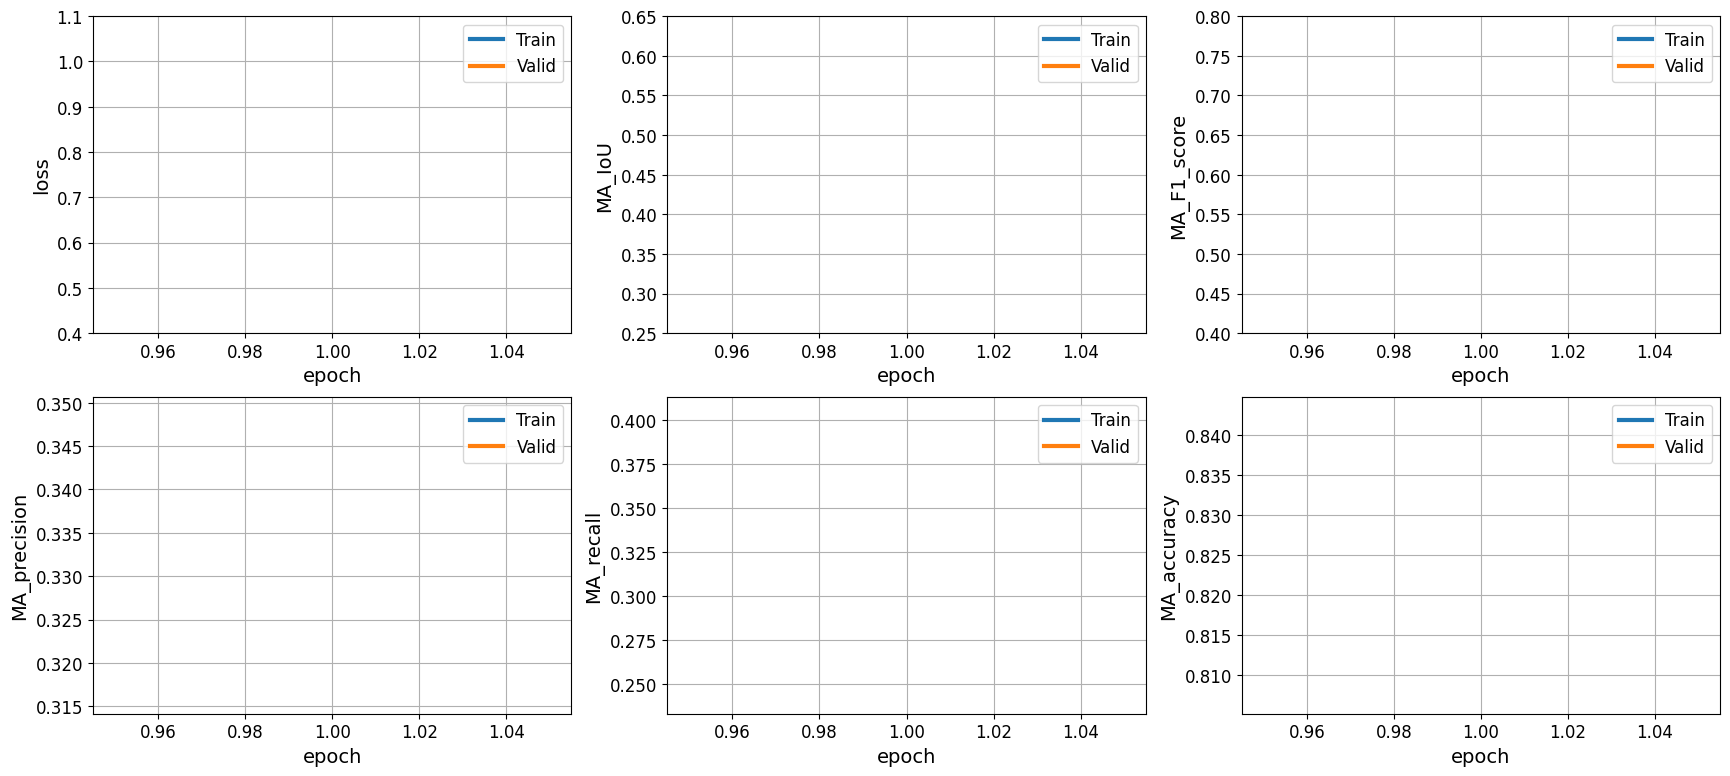

In [93]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_vgg.pt",
                                                          "results_vgg.csv")

plot_results("checkpoint_vgg.pt", "results_vgg.csv")


In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # print GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))


1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [95]:
TEST = True

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_vgg.pt",
                  "results_vgg.csv",
                  "confusion_matrix_vgg.csv")

Test: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s]


In [96]:
pd.read_csv("./results/testvgg_results_vgg.csv").iloc[:, np.arange(0, 12, 2)].style.hide()

loss,MA_IoU,MA_accuracy,MA_precision,MA_recall,MA_F1_score
1.301046,0.272155,0.847566,nan,0.387766,nan


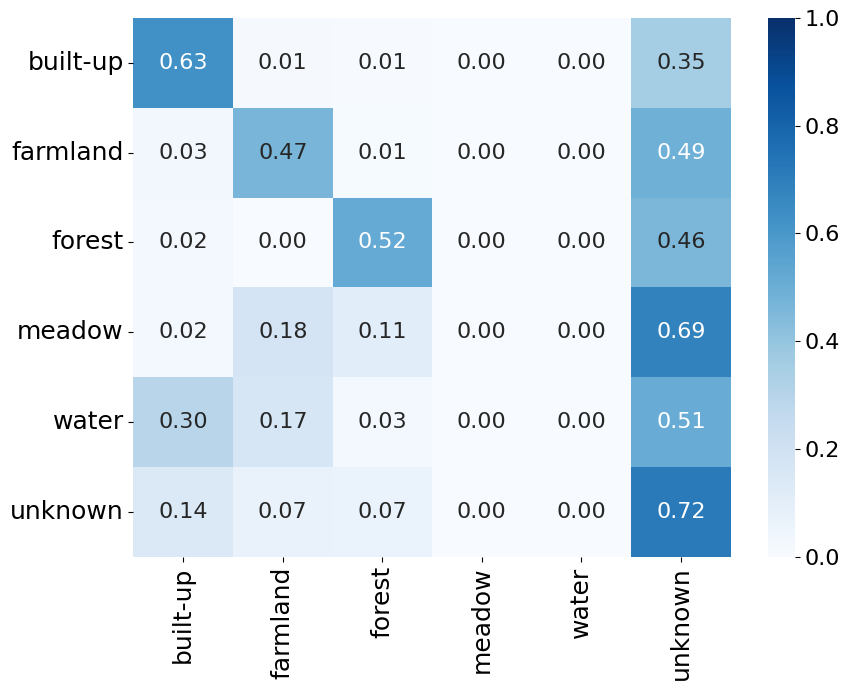

In [99]:
plot_CM(class_names, "confusion_matrix_vgg.csv")

In [100]:
# def load_checkpoint(model, criterion, optimizer, scheduler, checkpoint_name = "checkpoint_vgg.pt"):
    
#     checkpoint = torch.load(os.path.join("./checkpoints", checkpoint_name))
#     model.load_state_dict(checkpoint["model_state_dict"])
#     criterion.load_state_dict(checkpoint["criterion_state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#     if bool(checkpoint["scheduler_state_dict"]):
#         scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        
#     return model, criterion, optimizer, scheduler

def load_checkpoint(model, optimizer, scheduler=None, checkpoint_name="checkpoint_vgg.pt"):
    """Load model, optimizer, and optionally scheduler from checkpoint.

    Args:
        model (torch.nn.Module): Model to be loaded.
        optimizer (torch.optim.Optimizer): Optimizer to be loaded.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Defaults to None.
        checkpoint_name (str, optional): Checkpoint filename. Defaults to "checkpoint_vgg.pt".

    Returns:
        model (torch.nn.Module): Loaded model.
        optimizer (torch.optim.Optimizer): Loaded optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Loaded scheduler, if applicable.
    """
    checkpoint = torch.load(os.path.join("./checkpoints", checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler and checkpoint["scheduler_state_dict"]:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    return model, optimizer, scheduler


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    # Release all unoccupied cached memory
    torch.cuda.empty_cache()
    # Print GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))


1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [102]:
model = VGG16()
model = model.to(device)

# criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weight).float())
# criterion = criterion.to(device)
# optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

# N_EPOCHS = 1
# scheduler = None

# # load checkpoint
# model, criterion, optimizer, scheduler = load_checkpoint(model,
#                                                          criterion,
#                                                          optimizer,
#                                                          scheduler,
#                                                          checkpoint_name = "checkpoint_vgg.pt")
import numpy as np
class_weight = np.array([0.5, 1, 2, 1, 1.5, 0.8])
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weight).float())
criterion = criterion.to(device)

# Initialize Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = None

N_EPOCHS = 1

# Load Checkpoint
model, optimizer, scheduler = load_checkpoint(model, optimizer, scheduler, "checkpoint_vgg.pt")

c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


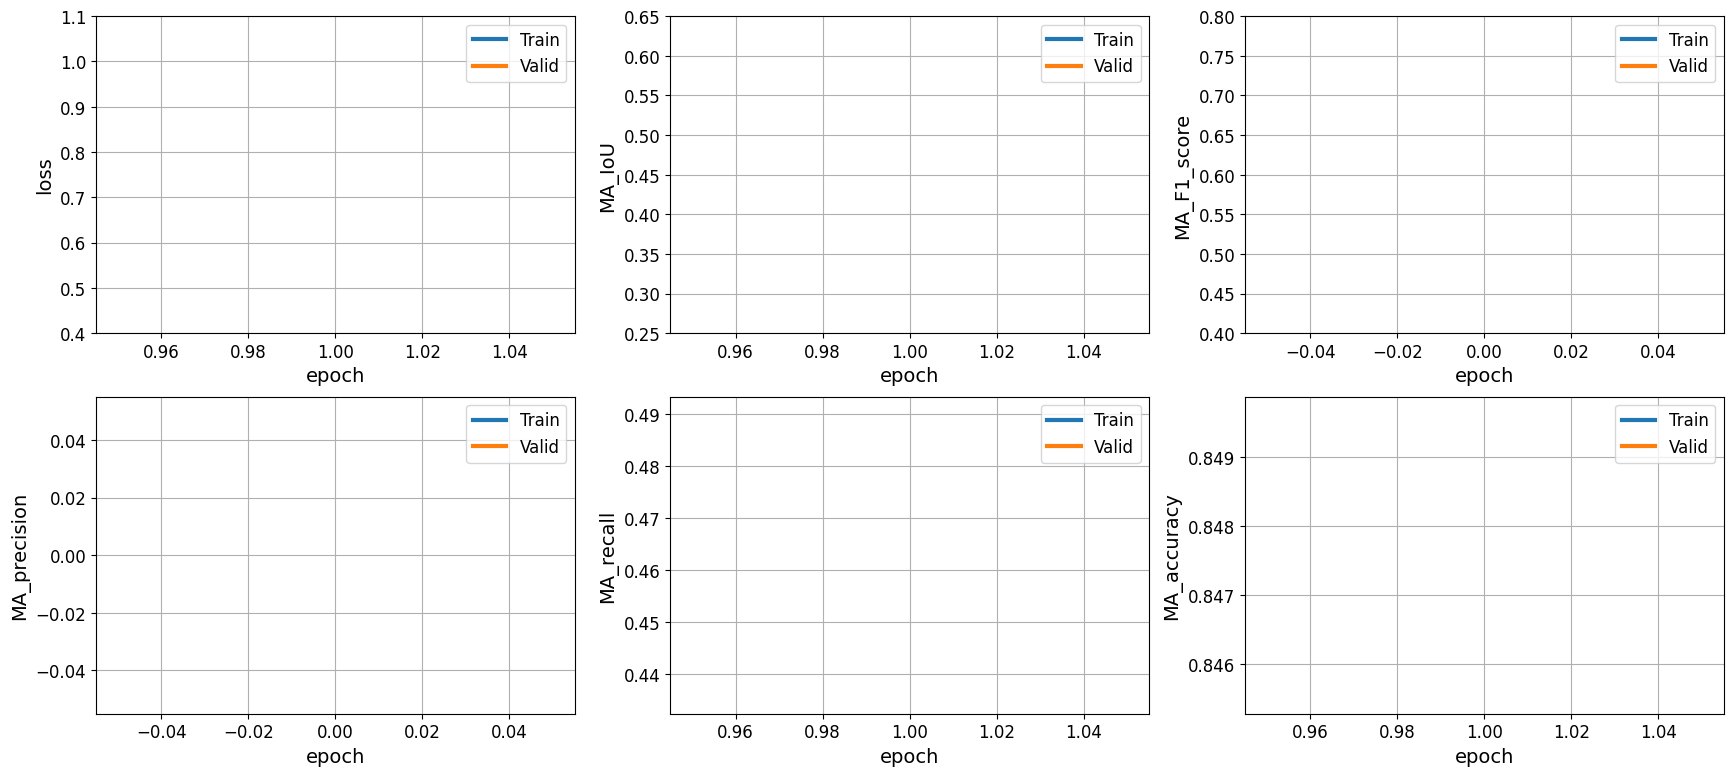

In [103]:
TRAIN = False

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_1vgg.pt",
                                                          "results_1vgg.csv")

plot_results("checkpoint_1vgg.pt", "results_1vgg.csv")


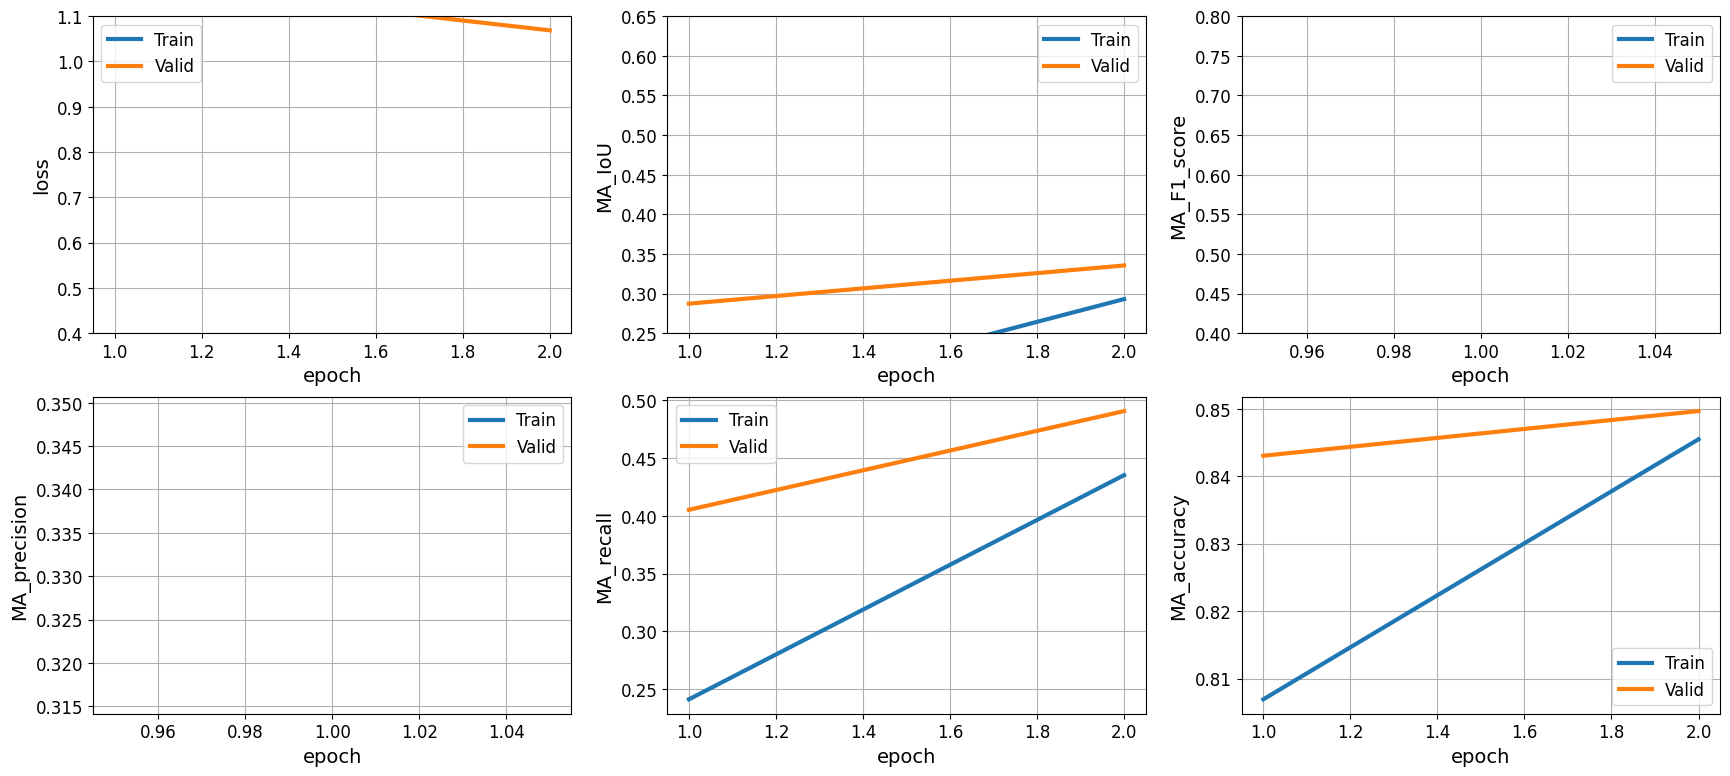

In [104]:
plot_results(["checkpoint_vgg.pt", "checkpoint_1vgg.pt"], ["results_vgg.csv", "results_1vgg.csv"])

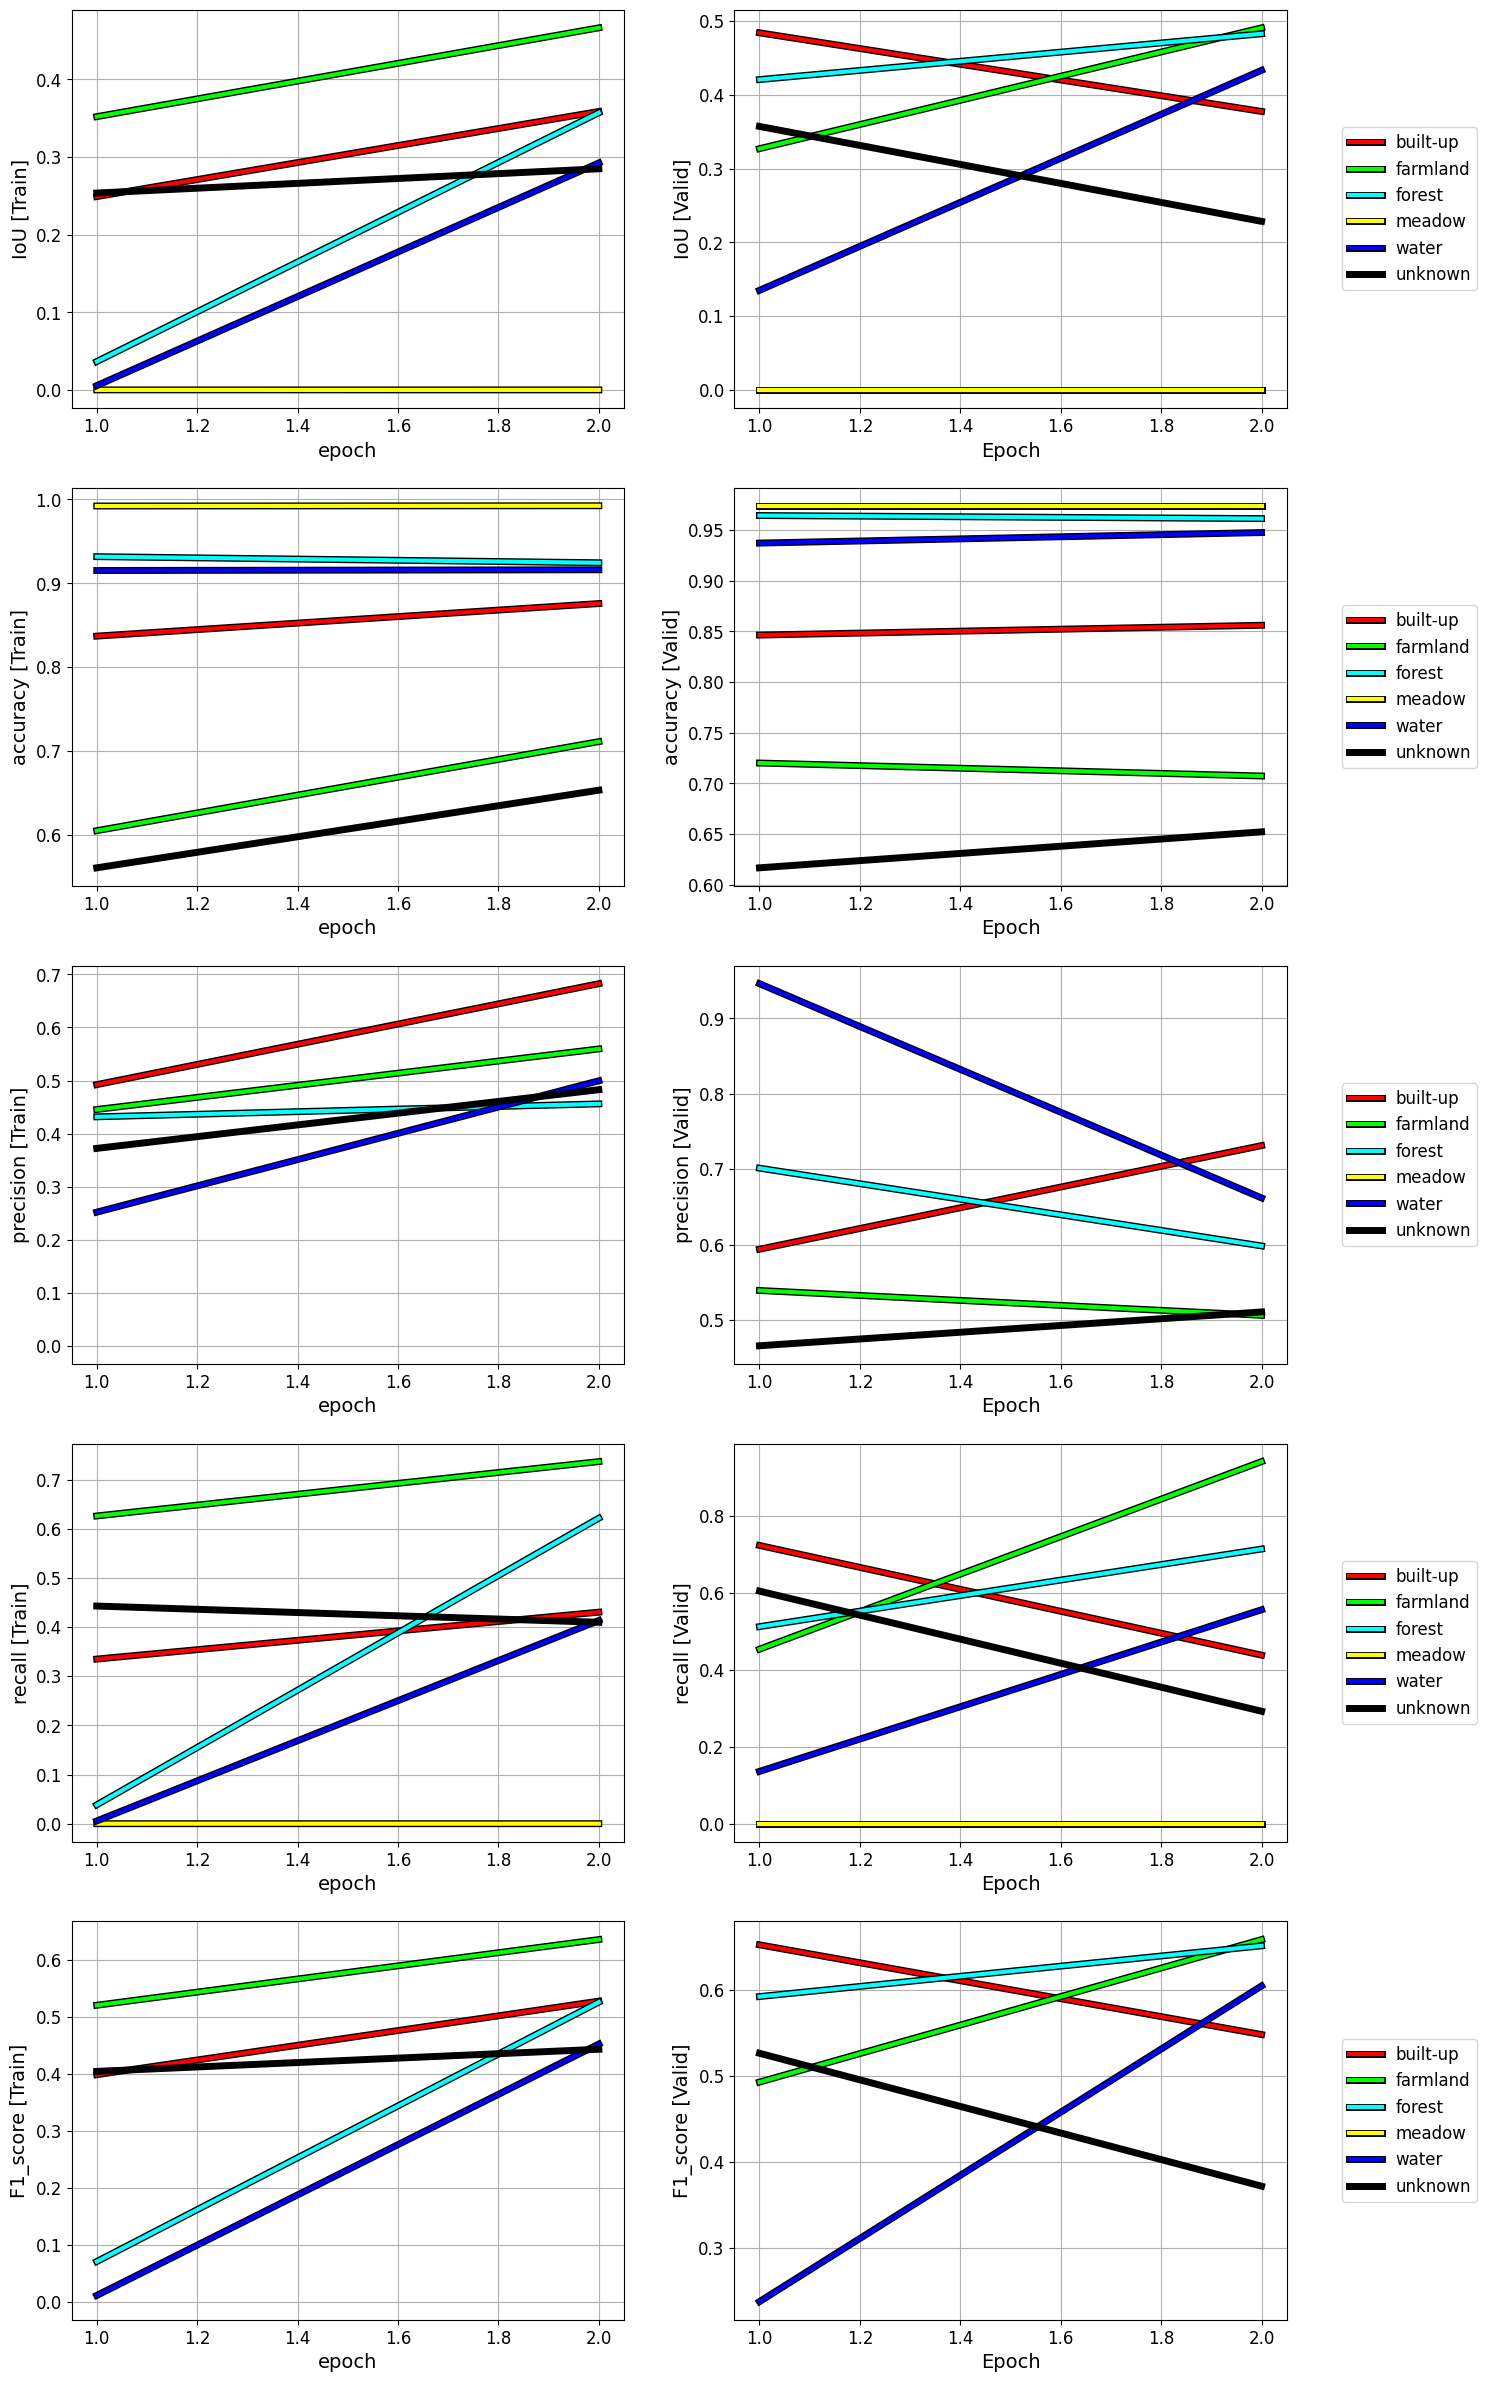

In [105]:
plot_results_per_class(class_names, class_rgb_values, ["checkpoint_vgg.pt", "checkpoint_1vgg.pt"], ["results_vgg.csv", "results_1vgg.csv"])

In [106]:
def plot_results_per_class_report(class_names, class_rgb_values, checkpoint_name = "checkpoint_vgg.pt", results_name = "results_vgg.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
            
    n_epochs = len(valid_results_df)
    n_classes = len(class_names) 
    valid_metric = np.zeros((n_epochs, n_classes))
    for i in range(n_epochs):
        valid_metric[i] = np.array(json.loads(valid_results_df["IoU"].iloc[i].replace("nan", "NaN")))
     
    plt.figure(figsize = (10, 7))   
    plt.subplot(1,1,1)
    
    for i in range(n_classes): 
        plt.plot(np.arange(n_epochs) + 1, valid_metric[:,i],
                 linewidth = 3,
                 color = np.array(class_rgb_values[i])/255,
                 label = [s.split("_")[0] for s in class_names][i],
                 path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        
    plt.plot(np.arange(n_epochs) + 1, np.mean(valid_metric[:,:-1], axis = 1),
             linewidth = 4,
             linestyle = "-",
             color = "red",
             label = "MIoU")
     
    plt.xlabel("epoch", fontsize = 18)
    plt.ylabel("IoU", fontsize = 18)
    plt.xticks(fontsize = 16)
    plt.yticks(np.arange(0, 1+0.2, 0.2), fontsize = 16)
    plt.grid(ls = "--")
    
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),
               loc = "lower left",
               mode = "expand",
               borderaxespad = 0,
               ncol = 4,
               fontsize = 18)
    
    plt.show()

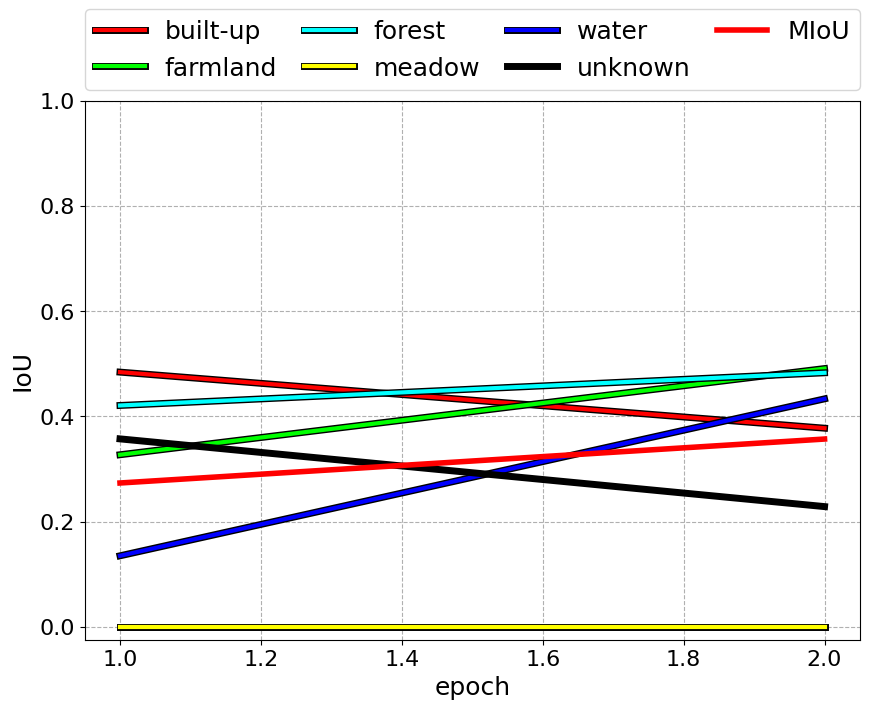

In [107]:
plot_results_per_class_report(class_names, class_rgb_values, ["checkpoint_vgg.pt", "checkpoint_1vgg.pt"], ["results_vgg.csv", "results_1vgg.csv"])

In [108]:
TEST = True

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_1vgg.pt",
                  "results_1vgg.csv",
                  "confusion_matrix_1vgg.csv")

Test: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


In [109]:
pd.read_csv("./results/testvgg_results_1vgg.csv").iloc[:,np.arange(0, 12, 2)].style.hide()

loss,MA_IoU,MA_accuracy,MA_precision,MA_recall,MA_F1_score
1.220837,0.289923,0.837869,nan,0.444879,nan


In [110]:
for metric in ["IoU", "F1_score"]:
    arr = json.loads(pd.read_csv("./results/testvgg_results_1vgg.csv")[metric].iloc[-1].replace("nan", "NaN"))
    arr = np.array(arr)
    print(f"MA_{metric} (6 classes):", np.mean(arr[:-1]))

MA_IoU (6 classes): 0.2944075882434845
MA_F1_score (6 classes): nan


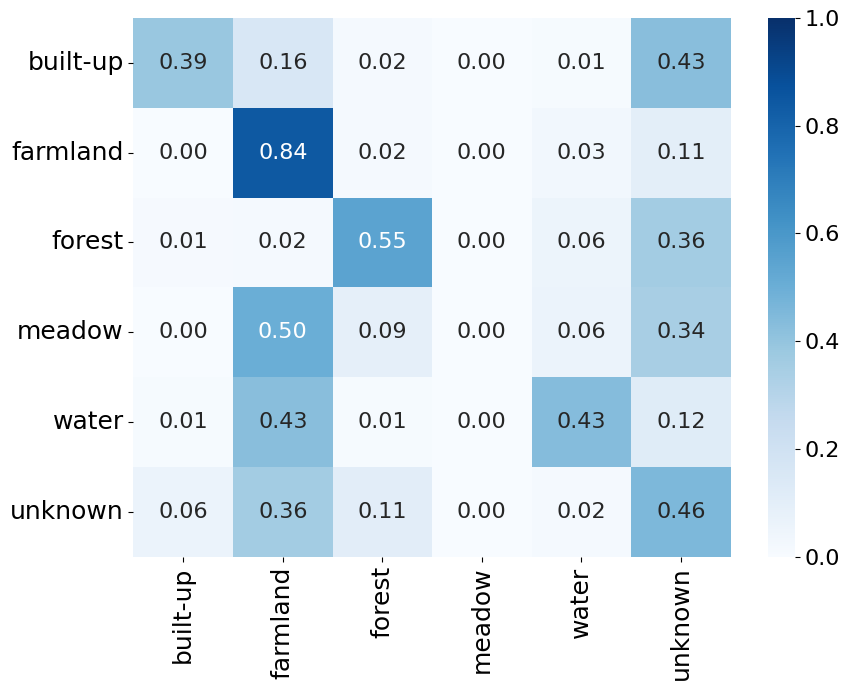

In [111]:
plot_CM(class_names, "confusion_matrix_1vgg.csv")

In [112]:
metadata_df = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"))

# select only images with masks
metadata_df = metadata_df[metadata_df["split"]=="train"]

# drop "split" column
metadata_df = metadata_df[["image_id", "sat_image_path", "mask_path"]]

# modify the path of images and masks
metadata_df["sat_image_path"] = metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
metadata_df["mask_path"] = metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))

metadata_df.head()

,image_id,sat_image_path,mask_path
0,GF2_PMS1__L1A0001015649-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
1,GF2_PMS1__L1A0001094941-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
2,GF2_PMS1__L1A0000575925-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
3,GF2_PMS1__L1A0001118839-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
4,GF2_PMS1__L1A0001064454-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...


In [113]:
def predict_image(model, image, mask, CUT_IMAGE = True):
    
    # normalize
    image = (image - train_mean)/train_std

    # cut image in patches of 224 pixels, make the predictions, and put them together
    if CUT_IMAGE:
        
        patch_size = 128

        if(image.shape[0] != image.shape[1]): raise ValueError("Image should be squared")

        crop_size = patch_size*(image.shape[0]//patch_size)
        
        # central crop
        s = image.shape[1]/2 - crop_size/2
        crop_image = image[int(s):int(s+crop_size), int(s):int(s+crop_size), :]
        crop_mask = mask[int(s):int(s+crop_size), int(s):int(s+crop_size), :]

        model.to(device)

        # set evaluation mode
        model.eval()

        # disable gradient tracking
        torch.no_grad()
        
        predict_mask = np.zeros_like(crop_mask)

        for i in range(crop_image.shape[0]//patch_size):
            for j in range(crop_image.shape[0]//patch_size):

                patch = crop_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]

                # transform from numpy array (H,W,C) to torch tensor (C,H,W)
                patch = torch.from_numpy(patch).permute(2, 0, 1).to(device)

                # add dummy dimension for batch
                patch = patch[None, :]

                logits_mask = model(patch.float()) # (1, C, H, W)
                prob_mask = F.softmax(logits_mask, dim=1) # (1, C, H, W)
                pred_mask = prob_mask.argmax(dim=1)[0] # (H, W)
                pred_mask_rgb = dense_to_rgb_encoding(pred_mask.cpu(), class_rgb_values) # (H, W, 3)
                
                # saving patches
                predict_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = pred_mask_rgb
                        
    else:
        
        if image.shape[0]%16 != 0 : raise ValueError("Image shape should be a multiple of 16")
            
        model.to("cpu")
            
        # set evaluation mode
        model.eval()

        # disable gradient tracking
        torch.no_grad()

        # transform from numpy array (H,W,C) to torch tensor (C,H,W)
        sample = torch.from_numpy(image).permute(2, 0, 1)
        
        # add dummy dimension for batch
        sample = sample[None, :]

        logits_mask = model(sample.float()) # (1, C, H, W)
        prob_mask = F.softmax(logits_mask, dim=1) # (1, C, H, W)
        pred_mask = prob_mask.argmax(dim=1)[0] # (H, W)
        predict_mask = dense_to_rgb_encoding(pred_mask, class_rgb_values) # (H, W, 3)
    
    return predict_mask

In [114]:
def plot_prediction(model, image, mask, CUT_IMAGE = True):
    
    pred_mask = predict_image(model, image, mask, CUT_IMAGE = CUT_IMAGE)
    
    # crop to plot the same shape
    if mask.shape != pred_mask.shape:
        s = image.shape[1]/2 - pred_mask.shape[0]/2
        image = image[int(s):int(s+pred_mask.shape[0]), int(s):int(s+pred_mask.shape[0]), :]
        mask = mask[int(s):int(s+pred_mask.shape[0]), int(s):int(s+pred_mask.shape[0]), :]

    # plot image
    
    fig = plt.figure(figsize = (15, 5))
    fig.subplots_adjust(wspace = 0.02, hspace = 0.02)#, top = 0.8)
    
    idx = 1
    
    plt.subplot(1,3,idx)
    idx += 1
    plt.imshow(pred_mask)
    plt.title("Prediction", fontsize = 24, pad = 10)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1,3,idx)
    idx += 1
    plt.imshow(image)
    plt.title("Input image", fontsize = 24, pad = 10)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,idx)
    idx += 1
    plt.imshow(mask)
    plt.title("Ground truth", fontsize = 24, pad = 10)
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig("./images/Vgg_pred_patches_2.png", dpi = 300, bbox_inches = "tight") if CUT_IMAGE else \
    plt.savefig("./images/Vgg_pred_full_2.png", dpi = 300, bbox_inches = "tight")
    
    plt.show()

selected image id: GF2_PMS1__L1A0001015649-MSS1


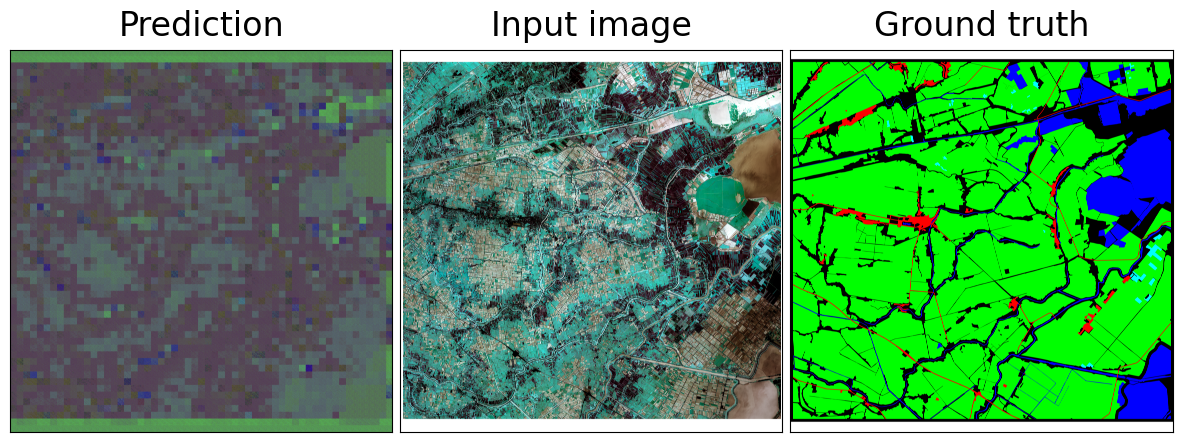

In [115]:
# [713813, 208495, 186739, 53987, 897901, 942986, 632489, 882451, 454655, 172307]
sample_image_id = 'GF2_PMS1__L1A0001015649-MSS1' #test_df["image_id"].sample(1, ignore_index = True).iloc[0]
print("selected image id:", sample_image_id)

sample_image_path = metadata_df[metadata_df["image_id"] == sample_image_id]["sat_image_path"].iloc[0]
sample_mask_path = metadata_df[metadata_df["image_id"] == sample_image_id]["mask_path"].iloc[0]

image = cv2.cvtColor(cv2.imread(sample_image_path),cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(sample_mask_path),cv2.COLOR_BGR2RGB)

plot_prediction(model, image, mask, CUT_IMAGE = True)